# sprint 機械学習スクラッチ クラスタリング

In [1477]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
import random
from matplotlib import cm

In [322]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, n_clusters, n_init, max_iter, tol=None, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        # 推定用
        self.sse = 0
        self.centers = 0
        self.cluster_num = 0
        
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        """
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
        
        # 指定した回数初期値を変更
        for n in range(self.n_init):
            # 中心点の初期値を決める
            centers = gain_centers(self, X)

            # 繰り返し（指定回数分）
            for i in range(self.max_iter):
                # SSEを求める
                sse = gain_sse(X, centers)
                
                # sse_minの初期化（学習初回のsseを初期値とする）
                if n==0 and i==0:
                    self.sse = sse
                
                # クラスタへの割り当て
                cluster_num = gain_cluster_num(X, centers)
                
                ### 確認用
#                 print("centers", centers)
#                 print("sse", sse)
#                 print("cluster_num", cluster_num)
#                 print("", )
                
#                 scatter_color = ['green', 'red', 'blue', 'Black', 'LightGreen', 'Brown',
#                                 'Yellow', 'LemonChiffon', 'Violet', "orangered"]
#                 for z in set(cluster_num):
#                     plt.scatter(X[cluster_num==z][:, 0],
#                                 X[cluster_num==z][:, 1],
#                                  label=z, color=scatter_color[z])
#                     plt.xlabel('X1')
#                     plt.ylabel('X2')
#                     plt.legend()
#                 plt.show()
                ###
                
                 # 最小のSSE、その時の中心点とクラスを記録、保持
                if sse <= self.sse:
                    self.sse = sse
                    self.centers = centers
                    self.cluster_num = cluster_num

                # 中心点の移動
                centers, center_error = move_centers(self, X, cluster_num, centers)

                # 中心点と重心の差がで指定した閾値以下で終了
                if self.tol and center_error <= self.tol:
                    return
        
        return
        
    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        # クラスタへの割り当て
        cluster_num = gain_cluster_num(X, self.centers)
        
        return cluster_num

# クラスタリングのための人工データセット

In [323]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4,
                  cluster_std=0.5, shuffle=True, random_state=0)

# 【問題1】中心点の初期値を決める
入力されたデータから K 個の中心点 μ1 から μK の初期値を決めるコードを作成してください。
K は指定したクラスタ数です。


最もシンプルな初期値の決定方法は、データ点 Xn の中からランダムに K 個選ぶことです。今回はこれを実装してください。


K-meansの学習結果は中心点 μ の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。



In [324]:
def gain_centers(self, X):
    
    # ランダムにXのインデックスを中心点の数だけ取得
    center_index = random.sample(list(range(X.shape[0])), self.n_clusters)
    
    # 取得したランダムなインデックスのXをreturn
    return X[center_index, :]

# 【問題2】SSEを求める関数の作成
クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。


K-meansはこのSSEを最小化する rnk と μk を求めることが目的となります。複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。

$$SSE = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2$$

In [426]:
def gain_sse(X, centers):
    
    # 各クラスタとデータ点の距離を算出
    errors = np.zeros((X.shape[0], centers.shape[0]))
    for n in range(centers.shape[0]):
        errors[:, n] = ((X - centers[n, :])**2).sum(axis=1)
     
    # それぞれのデータ点に対し、最も距離の近いクラスタ毎にクラスタリング
    # 各Xのクラスタ番号を記録、保持（確認用）    
    X_cluster_num = errors.argmin(axis=1)
    
#    ### 確認用
#     print('errors  gain_see', errors)
#     ###
    
     # 各クラスタ毎にSSEを算出し合算
    return errors.min(axis=1).sum()

# 【問題3】クラスタへの割り当て
全てのデータ点 Xn を最も近い中心点 μk に割り当てるコードを作成してください。


K-menasにおける 近い とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル p,q に対しては以下の数式で表現できます。

$$\|q-p\| = \sqrt{(q-p)\cdot(q-p)}$$

In [425]:
def gain_cluster_num(X, centers):
    
    # 各クラスタとデータ点のノルムを算出
    errors = np.zeros((X.shape[0], centers.shape[0]))
    for n in range(centers.shape[0]):
        # np.linalg.norm
        errors[:, n] = np.linalg.norm(X - centers[n, :], axis=1)
    
#     ### 確認用
#     print('errors  gain_cluster_num', errors)
#     ###
    
    # ノルム最小のクラスへ割り当て
    return errors.argmin(axis=1)

# 【問題4】中心点の移動
中心点 μk を k 番目のクラスタに割り当てられる全てのデータ点 Xn の平均値（重心）に移動するコードを作成してください。


クラスタの割り当て rnk を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

In [424]:
def move_centers(self, X, cluster_num, centers):
    
    # 新たなクラスタ中心の初期化
    new_centers = np.zeros_like(centers)
    
    # クラス毎に繰り返し
    for n in set(cluster_num):
        X_n = X[cluster_num==n]
                
        # 中心点の算出
        new_centers[n] = X_n.mean(axis=0)
    
#     ### 確認用
#     print("move_centers")
#     print('X', X)
#     print("cluster_num", cluster_num)
#     print('centers', centers)
#     print('')
#     ###
    
    # 新たな中心点、中心点と重心の差を出力
    return new_centers, np.linalg.norm(new_centers - centers, axis=1).sum()

# 【問題5】繰り返し
クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。


次のどれかの条件を満たしたらこれを止めます。


* 繰り返しが指定した回数に到達する。（雛形では引数max_iter）
* 中心点 μk と重心の差が指定した許容値以下になる。（雛形では引数tol）

# 【問題6】異なる初期値で計算
問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。


複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 μk を保持しておきます。

# 【問題7】推定
新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。


* データ点 Xn と学習で決まった中心点 μk に対し、 SSE を最小化する rnk を選ぶ。

具体的には次のことです。


* データ点 Xn を最も近い μk に割り当てる。

In [339]:
skm = ScratchKMeans(n_clusters=4, n_init=50, max_iter=500, tol=0.001)
skm.fit(X)
pred = skm.predict(X)
print(pred)
print("SSE : ", skm.sse)

[2 1 2 2 2 2 0 1 2 1 1 1 1 1 1 3 3 0 0 3 2 1 0 3 2 0 0 2 3 3 3 1 3 3 0 2 1
 3 1 0 2 0 1 0 0 1 3 0 2 2 2 3 0 0 0 1 1 3 3 1 1 3 3 2 3 1 0 0 3 2 1 3 2 1
 2 2 0 0 3 3 3 1 0 2 3 0 3 3 2 2 2 0 2 0 0 1 1 0 1 2]
SSE :  48.63378320706403


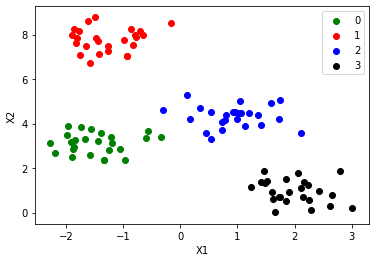

In [340]:
scatter_color = ['green', 'red', 'blue', 'Black', 'LightGreen', 'Brown',
                                'Yellow', 'LemonChiffon', 'Violet', "orangered"]
for n in set(pred):
    plt.scatter(X[pred==n][:, 0], X[pred==n][:, 1],
                label=n, color=scatter_color[n])
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

# 【問題8】エルボー法の実装
K-meansにおいて中心点の個数 k は人為的に決める必要がありますが、その判断方法としてエルボー法があります。エルボー法により中心点の個数 k を検討するためのコードを作成してください。


SSEを縦軸、クラスタ数 k を横軸にした折れ線グラフを表示します。このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

In [336]:
sse_list = []
k_num = 10
for k in range(k_num):
    skm_k = ScratchKMeans(n_clusters=k+1, n_init=50, max_iter=500, tol=0.001)
    skm_k.fit(X)
    sse_list.append(skm_k.sse)

In [337]:
sse_list

[870.2611797855421,
 351.48372865125435,
 139.17097772033807,
 48.63378320706403,
 45.703855297573085,
 37.770460525082754,
 34.97188479627216,
 32.818078370009665,
 28.757515809697185,
 26.726937178218048]

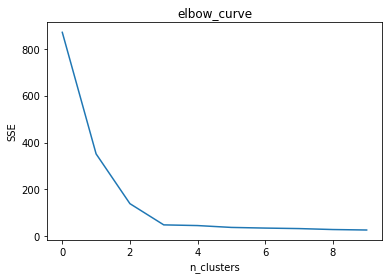

In [338]:
plt.plot(sse_list)
plt.xlabel('n_clusters')
plt.ylabel("SSE")
plt.title('elbow_curve');

# 【問題9】（アドバンス課題）シルエット図
k を決める助けになるものとしてシルエット図もあります。シルエット図を表示するコードを作成してください。

In [1529]:
# 初期値設定
cluster_labels = list(set(pred))
a = np.zeros_like(pred)
b = np.zeros_like(pred)
silhouette_vals = np.zeros_like(pred)
# サンプル毎のインデックス
n = 0

# シルエット係数の計算
# クラス毎にfor
for label in cluster_labels:
    # データ毎にfor
    for i in range(X[pred==label].shape[0]):
        # aの計算
        a[n] = np.linalg.norm(X[pred==label] - X[pred==label][i], axis=1).mean()
        
        # bの計算
        # 他クラスデータとの距離を全て算出
        b_all = np.linalg.norm(X[pred!=label] - X[pred==label][i], axis=1)
        # 他クラスとの距離の平均を算出
        b_means = [b_all[pred[pred!=label]==L].mean() for L in cluster_labels if L!=label]
        # 平均の中で最小を選択
        b[n] = min(b_means)
        
        # インデックスを更新
        n +=1

# シルエット係数を求める
ab_max = np.max(np.concatenate([a[:, np.newaxis], b[:, np.newaxis]], axis=1), axis=1)
silhouette_vals = (b - a)/ab_max

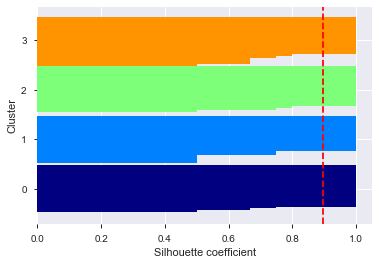

In [1528]:
# グラフ化
silhouette_avg = silhouette_vals.mean()
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[pred == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / len(cluster_labels))
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

# 卸売業者のデータ分析
クラスタリングを利用法を学ぶために、Wholesale customers Data Setを使用します。


UCI Machine Learning Repository: Wholesale customers Data Set


Data Folderの中からWholesale customers data.csvをダウンロードしてください。これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。顧客は小売店やレストランです。RegionとChannelは取り覗き、金額のデータでK-meansを利用します。

In [347]:
# データロード
data = pd.read_csv("Wholesale customers data.csv")
data = data.iloc[:, 2:]
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [348]:
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)
data_pca[:5, :]

array([[  650.02212207,  1585.51909007],
       [-4426.80497937,  4042.45150884],
       [-4841.9987068 ,  2578.762176  ],
       [  990.34643689, -6279.80599663],
       [10657.99873116, -2159.72581518]])

[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


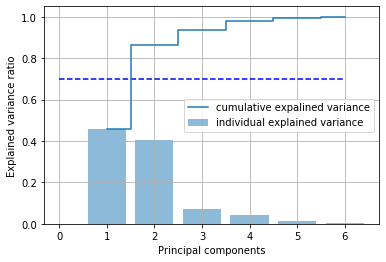

In [349]:
pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

# 【問題10】クラスタ数kの選択
最適だと思われるクラスタ数 k を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

In [595]:
# 学習、クラスタ数を変化
sse_list_w = []
k_num_w = 15
for k in range(k_num_w):
    skm_w = ScratchKMeans(n_clusters=k+1, n_init=50, max_iter=500, tol=0.0001)
    skm_w.fit(data_pca)
    sse_list_w.append(skm_w.sse)

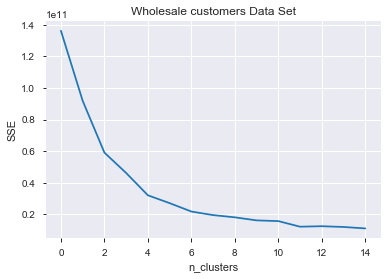

In [596]:
# エルボープロット
plt.plot(sse_list_w)
plt.xlabel('n_clusters')
plt.ylabel("SSE")
plt.title('Wholesale customers Data Set');

In [597]:
# k=6で学習
skm_w6 = ScratchKMeans(n_clusters=6, n_init=50, max_iter=500, tol=0.0001)
skm_w6.fit(data_pca)
pred_w6 = skm_w6.predict(data_pca)

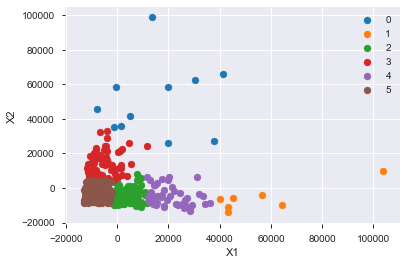

In [598]:
# k=6　グラフ化
for n in set(pred_w6):
    plt.scatter(data_pca[pred_w6==n][:, 0], data_pca[pred_w6==n][:, 1], label=n)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

## エルボープロットより、k＝６でSSE減少の傾きが小さくなっている　 →　k＝６に設定

# 【問題11】既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

In [599]:
data2 = pd.read_csv("Wholesale customers data.csv")
data2 = data2.iloc[:, :2]
data2.head()

,Channel,Region
0,2,3
1,2,3
2,2,3
3,1,3
4,2,3


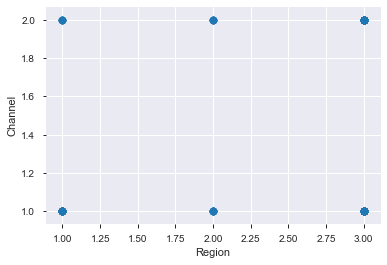

In [600]:
plt.scatter(data2["Region"], data2["Channel"])
plt.xlabel('Region')
plt.ylabel("Channel");

 ## ・RegionとChannelのグラフでは綺麗に「６グループ」に別れている
 ## ・作成したクラスタでは各々のクラスタ境界が不明瞭

# 【問題12】卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。

《ヒント》


前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。


条件ごとにデータを見る際にはPandasのgroupbyが便利です。

In [601]:
import pandas_profiling as pdp

# クラスタ番号の列を追加
data_k = pd.concat([data, pd.DataFrame(pred_w6, columns=['class'])], axis=1)
data_k.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,class
0,12669,9656,7561,214,2674,1338,2
1,7057,9810,9568,1762,3293,1776,5
2,6353,8808,7684,2405,3516,7844,5
3,13265,1196,4221,6404,507,1788,2
4,22615,5410,7198,3915,1777,5185,2


In [602]:
# データ確認
pdp.ProfileReport(data_k)

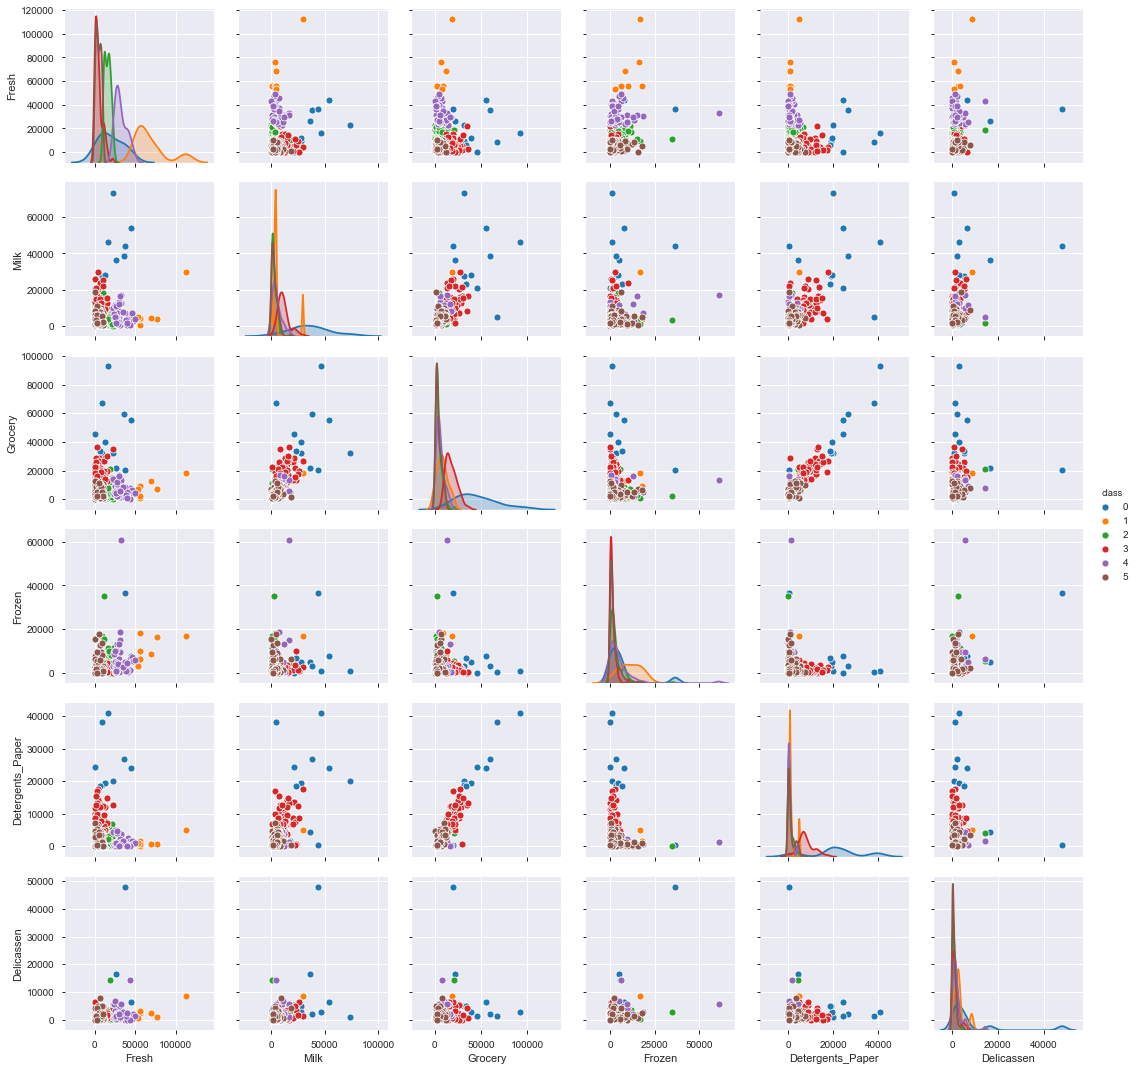

In [637]:
# ペアプロット
sns.pairplot(data_k, hue='class', vars=data.columns,  diag_kind="kde")
plt.show()

max


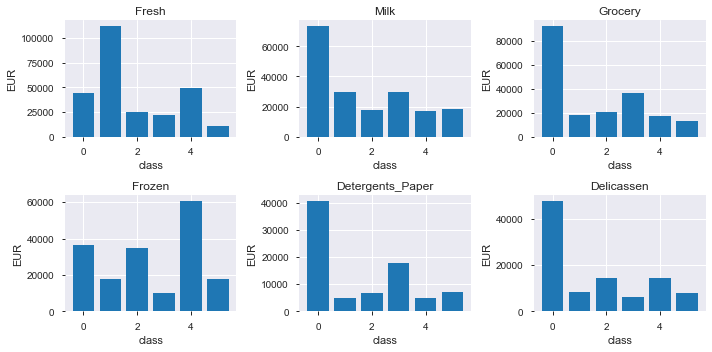

------------------------------------------------------------------------------------------------------------------------------------------------------
min


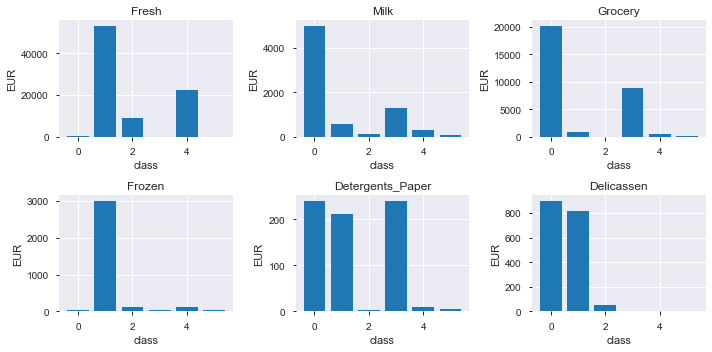

------------------------------------------------------------------------------------------------------------------------------------------------------
mean


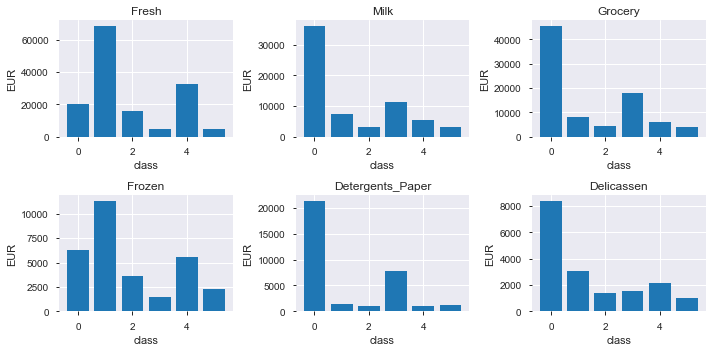

------------------------------------------------------------------------------------------------------------------------------------------------------
median


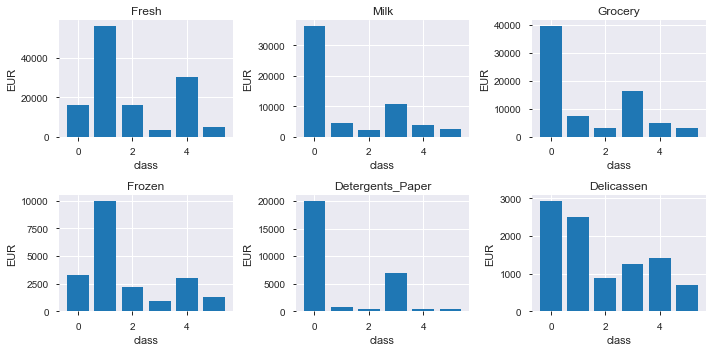

------------------------------------------------------------------------------------------------------------------------------------------------------
sum


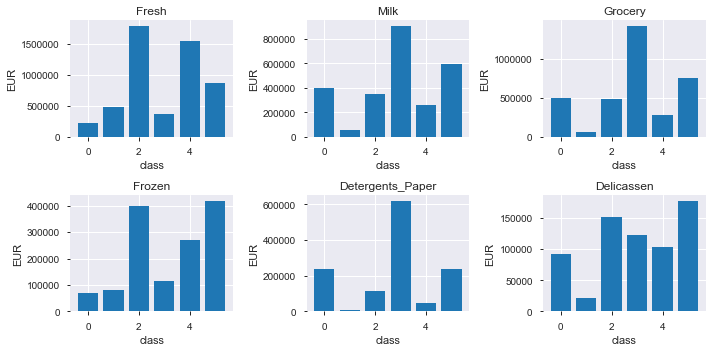

------------------------------------------------------------------------------------------------------------------------------------------------------


In [610]:
# 各クラスの統計量グラフ化
col_list = ["max", "min", "mean", "median", "sum"]
for cal in col_list:
    print(cal)
    plt.figure(figsize=(10,5))
    for i, column in enumerate(data.columns):
        plt.subplot(2,3, i+1)
        cal_df = data_k.groupby(["class"]).agg(cal)
        plt.bar(cal_df.index.values, cal_df[column].values)
        plt.xlabel('class')
        plt.ylabel('EUR')
        plt.title(column)
        plt.tight_layout()
    plt.show()
    print("-"*150)

In [672]:
# クラス毎の合計
data_k.groupby(['class']).sum()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
class,,,,,,
0,218771,397566,500692,69618,235588,92554
1,478868,51092,57127,79439,9866,21427
2,1790838,347077,481934,400227,114968,151518
3,372967,905588,1422316,114485,621708,123183
4,1547872,255467,281629,268330,49314,104147
5,870815,593567,754864,419551,236413,178114


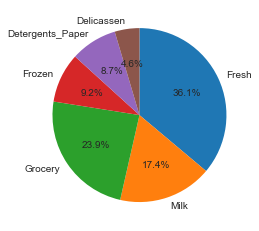

In [673]:
# 金額全体に対する各特徴量の割合
plt.pie(dict(data_k.groupby(['class']).sum().sum()).values(),
       labels=dict(data_k.groupby(['class']).sum().sum()).keys(),
       autopct="%1.1f%%", startangle=90, counterclock=False)
plt.show()

* 相関図より、Groceryよく買う人はMilkとDetergents_Paperをよく買う
* クラス0はMilk、Detergents_Paper、Grocery、Delicassen購入金額の最頻値、平均値が高い。
* クラス1はFresh、Frozen購入金額の最頻値、平均値が高い。Delicassen購入金額の最頻値が高い。
* クラス２はFresh、Frozen、Delicassenの購入金額の合計が高い。
* クラス３はMilk、Detergents_Paper、Groceryの購入金額の合計が高い。
* クラス４はFreshの購入金額の合計が高い。
* クラス５はFrozen、Milk、Delicassenの購入金額の合計が高い。
* Fresh、Milk、Groceryで金額全体の約８０％を占めている。

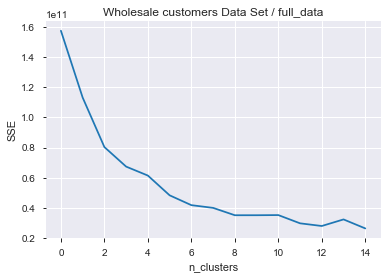

In [606]:
# full特徴量でクラスタリング

# 学習、クラスタ数を変化
sse_list_full = []
k_num_full = 15
for k in range(k_num_full):
    skm_full= ScratchKMeans(n_clusters=k+1, n_init=50, max_iter=500, tol=0.0001)
    # pandasをndarrayに変換して入力
    skm_full.fit(data.values)
    sse_list_full.append(skm_full.sse)
    
# エルボープロット
plt.plot(sse_list_full)
plt.xlabel('n_clusters')
plt.ylabel("SSE")
plt.title('Wholesale customers Data Set / full_data');

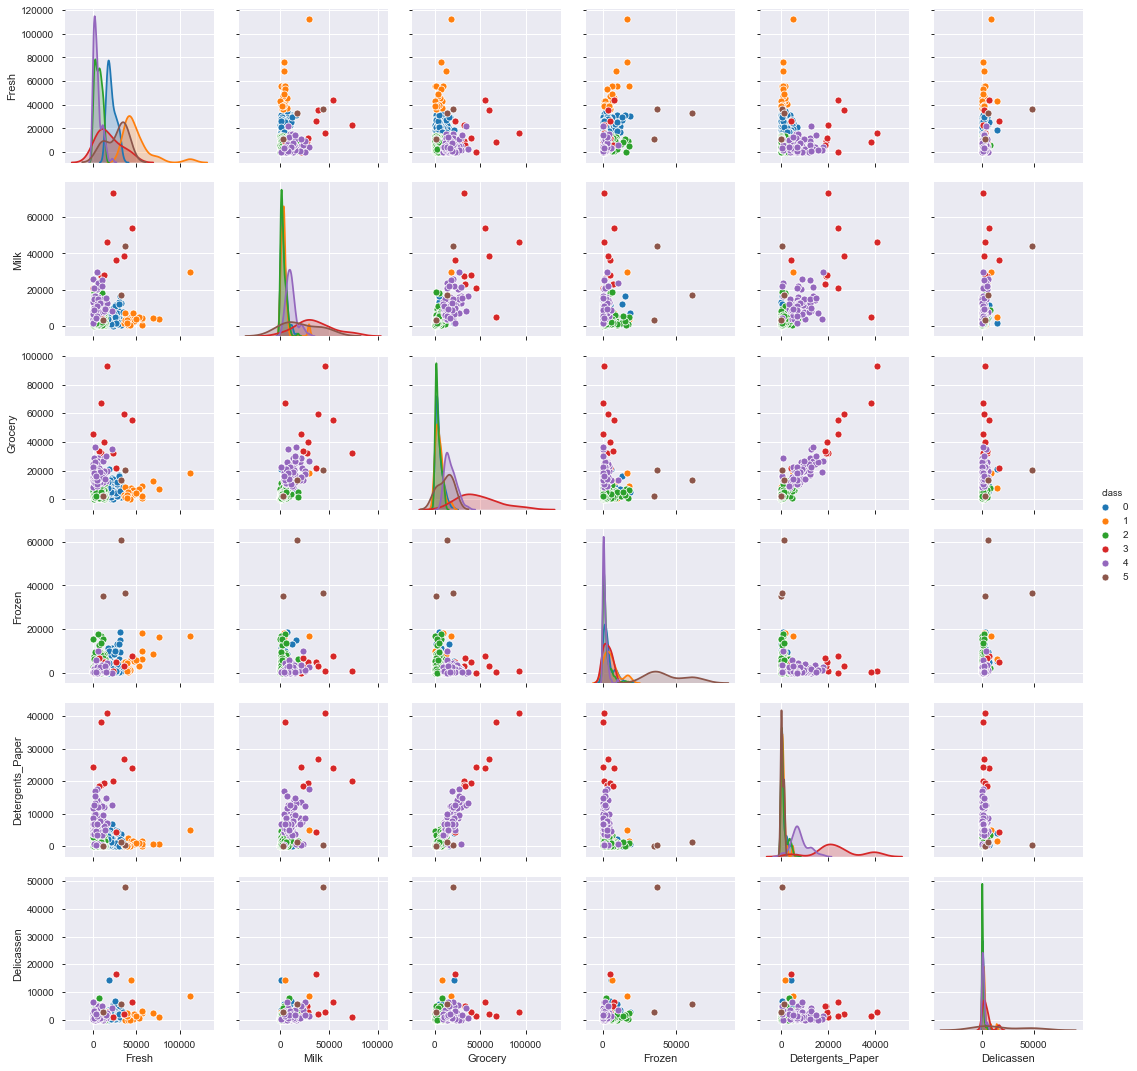

In [609]:
# 学習　full
skm_f6 = ScratchKMeans(n_clusters=6, n_init=50, max_iter=500, tol=0.0001)
skm_f6.fit(data.values)
pred_f6 = skm_f6.predict(data.values)

# クラスタ番号の列を追加
data_full_k = pd.concat([data, pd.DataFrame(pred_f6, columns=['class'])], axis=1)

# ペアプロット
sns.pairplot(data_full_k, hue='class', vars=data.columns)
plt.show()

* 次元削減したデータに比べクラスタリングの境界が不明瞭

# 【問題13】（アドバンス課題）他の手法の調査
今回扱ったK-means以外に非階層クラスタリングで有名な手法としては DBSCAN 、
PCA以外に次元削減手法で有名な手法としては t-SNE や LLE があります。


* DBSCANのメリット・デメリット
* t-SNE、LLEのメリット・デメリット

について記述してください。

## DBSCAN

メリット
* k-meansと異なり最初にクラスタ数を決めなくて良い
* クラスタが球状であることを前提としていない
* 外れ値に対しロバスト

デメリット
* border点の概念が微妙で，データによりどのクラスタに属するか変わる可能性がある。
* 距離の計算方法により，精度が変わる。
* ハイパーパラメータ調整が困難。特にデータが密集していると難しい。

## t-SNEのメリット・デメリット

メリット
* 非線形な関係を捉えることができる。
* 高次元データを次元圧縮し可視化することができる。
* 高次元空間上の類似度を低次元空間に表現することができる

デメリット
* うまくいくことが保証されているのは2or3次元への圧縮のみ。
* 局所構造が次元の呪いの影響を受けやすい。
* 最適化アルゴリズムの収束性が保証されていない。

## LLEのメリット・デメリット

メリット
* 非線形にも対応できる
* 高次元データも対応可能

デメリット
* データがひとまとまりになっていないと構造を捉えることができない

# 【問題14】（アドバンス課題）t-SNEとDBSCANの利用
Wholesale customersのデータに対して、PCAではなく、 t-SNE を用いて次元削減をしてください。さらにK-meansではなく、 DBSCAN を用いてクラスタリングしてください。


そのクラスタリング結果をPCA+kmeansの場合の結果と比較してみましょう。実装にはscikit-learnを用いてください。


sklearn.manifold.TSNE — scikit-learn 0.20.2 documentation


sklearn.cluster.DBSCAN — scikit-learn 0.20.2 documentation

《パラメーターチューニング》


これらはK-meansやPCAに比べパラメーターチューニングが難しい手法です。scikit-learnのドキュメントと共に論文も参考にしながらパラメータの意味を確認することも大切になります。

In [1298]:
# t-sne
from sklearn.manifold import TSNE
TSNE = TSNE(n_components = 2, perplexity=30)
data_TSNE = TSNE.fit_transform(data)
data_TSNE[:5, :]

array([[ -4.676217 ,   1.8671474],
       [ -0.7075389,  11.7966795],
       [  3.7984388,  10.061954 ],
       [  8.077179 , -15.872005 ],
       [-16.488504 ,  -8.775732 ]], dtype=float32)

In [1404]:
# DBSCAN
from sklearn.cluster import DBSCAN
DBSCAN = DBSCAN(eps=2.2, min_samples=4)
pred_DBSCAN = DBSCAN.fit_predict(data_TSNE)

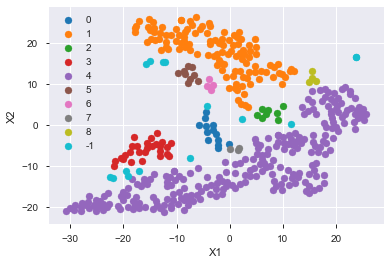

In [1406]:
# グラフ化
for n in set(pred_DBSCAN):
    plt.scatter(data_TSNE[pred_DBSCAN==n][:, 0],
                data_TSNE[pred_DBSCAN==n][:, 1], label=n)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

In [1407]:
# 各クラスの数
pd.DataFrame(pred_DBSCAN, columns=["class"])["class"].value_counts()

 4    240
 1    117
 3     27
-1     15
 0     13
 5      9
 2      8
 8      4
 6      4
 7      3
Name: class, dtype: int64

## sneのperplexity（複雑性）を少し下げ再トライ

In [ ]:
# t-sne
from sklearn.manifold import TSNE
TSNE_t = TSNE(n_components = 2, perplexity=10)
data_TSNE_t = TSNE_t.fit_transform(data)

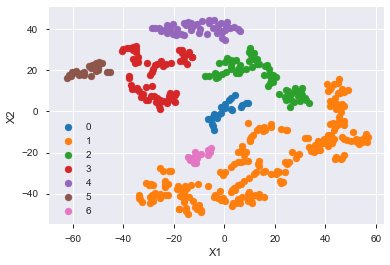

In [1475]:
from sklearn.cluster import DBSCAN
DBSCAN_t = DBSCAN(eps=6.5, min_samples=5)
pred_DBSCAN_t = DBSCAN_t.fit_predict(data_TSNE_t)
# グラフ化
for n in set(pred_DBSCAN_t):
    plt.scatter(data_TSNE_t[pred_DBSCAN_t==n][:, 0],
                data_TSNE_t[pred_DBSCAN_t==n][:, 1], label=n)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
plt.show()

In [1476]:
# 各クラスの数
pd.DataFrame(pred_DBSCAN_t, columns=["class"])["class"].value_counts()

1    206
2     66
3     65
4     46
5     23
0     21
6     13
Name: class, dtype: int64

* PCA+kmeansに比べ、各クラスタ境界が明確になった（気がする）
* クラスタの数がPCA+kmeansと異なる（クラス０、６はノイズ？）
* ハイパーパラメータの調整が難しい（特にt_sneのperplexityに変化に対し、次元削減後のグラフが大きく変化する）